In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stacked-minst-labeled/stacked_mnist_labeled.npz
/kaggle/input/weights/best_model_epoch14.pth


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os

In [3]:
import os
import numpy as np
from torchvision import datasets
from PIL import Image

def create_mnistrgb_with_labels(output_dir, mnist_dir, num_images=240000):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST(root=mnist_dir, train=True, download=True)
    images = train_dataset.data.numpy()  # Shape (60000, 28, 28)
    labels = train_dataset.targets.numpy()
    
    # Pre-pad all MNIST images upfront for efficiency
    padded_images = np.pad(images, [(0,0), (2,2), (2,2)], mode='constant')  # Now (60000, 32, 32)
    
    # Initialize storage
    stacked_images = np.empty((num_images, 32, 32, 3), dtype=np.uint8)
    stacked_labels = np.empty(num_images, dtype=np.int32)
    
    # Generate stacked images
    for i in range(num_images):
        # Randomly select 3 digits
        indices = np.random.choice(len(images), 3, replace=True)
        digit_labels = labels[indices]
        
        # Create RGB image using pre-padded images
        rgb_image = np.stack([
            padded_images[indices[0]],
            padded_images[indices[1]],
            padded_images[indices[2]]
        ], axis=-1)
        
        # Store results
        stacked_images[i] = rgb_image
        stacked_labels[i] = 100*digit_labels[0] + 10*digit_labels[1] + digit_labels[2]
    
    # Save compressed file
    np.savez_compressed(os.path.join(output_dir, 'stacked_mnist_labeled.npz'),
                       images=stacked_images,
                       labels=stacked_labels)

# Create the dataset
#create_mnistrgb_with_labels('/kaggle/working/stacked_mnist_240k/', 'mnist')

In [4]:
data = np.load('/kaggle/input/stacked-minst-labeled/stacked_mnist_labeled.npz')
images = data['images']  # Shape (240000, 32, 32, 3)
labels = data['labels']  # Shape (240000,)

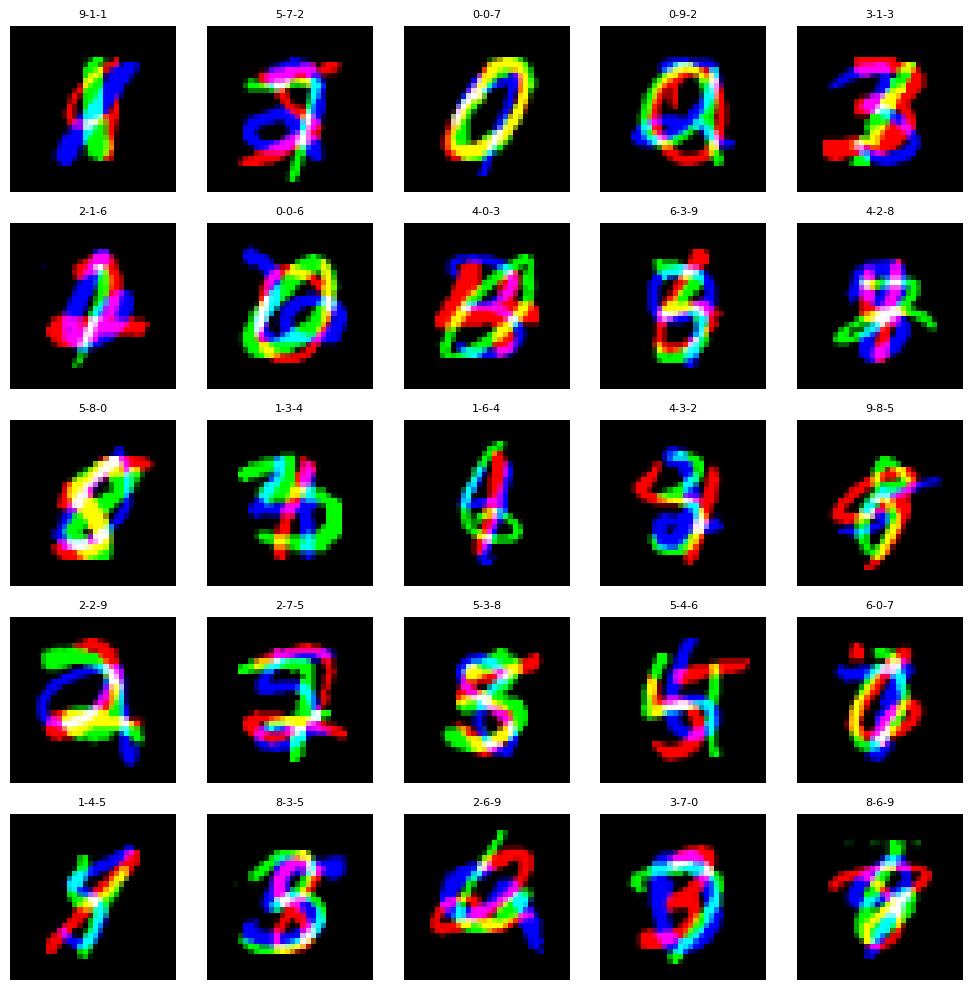

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = np.load('/kaggle/input/stacked-minst-labeled/stacked_mnist_labeled.npz')
images = data['images']
labels = data['labels']

# Visualize random samples
num_samples = 25  # 5x5 grid
random_indices = np.random.choice(len(images), num_samples, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[idx])
    label = str(labels[idx]).zfill(3)  # Convert to 3-digit string
    plt.title(f"{label[0]}-{label[1]}-{label[2]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

Unique modes: 1000
Average samples per mode: 240.0
Min/Max samples per mode: 160, 350


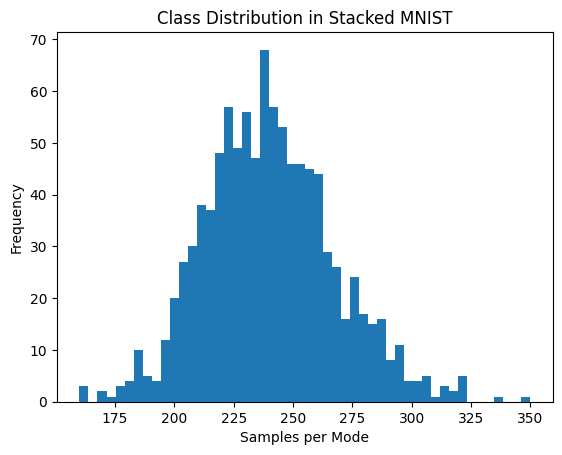

In [6]:
import numpy as np

# Load dataset
data = np.load('/kaggle/input/stacked-minst-labeled/stacked_mnist_labeled.npz', allow_pickle=True)
labels = data['labels']

# Count mode frequencies
unique_modes, counts = np.unique(labels, return_counts=True)
print(f"Unique modes: {len(unique_modes)}")
print(f"Average samples per mode: {counts.mean():.1f}")
print(f"Min/Max samples per mode: {counts.min()}, {counts.max()}")

# Plot histogram
plt.hist(counts, bins=50)
plt.xlabel('Samples per Mode')
plt.ylabel('Frequency')
plt.title('Class Distribution in Stacked MNIST')
plt.show()

In [7]:
class StackedMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.hundreds = nn.Linear(256, 10)
        self.tens = nn.Linear(256, 10)
        self.units = nn.Linear(256, 10)

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return self.hundreds(x), self.tens(x), self.units(x)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import f1_score
import os

# 1. Enhanced Data Preparation with Validation Split
data = np.load('/kaggle/input/stacked-minst-labeled/stacked_mnist_labeled.npz')
images = data['images'].transpose(0, 3, 1, 2)  # (N, 3, 32, 32)
labels = data['labels']

# Convert labels to 3 separate digits
digits = np.array([(l//100, (l//10)%10, l%10) for l in labels])

# Create proper train/val/test split (80/10/10)
total_samples = len(images)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split indices
indices = np.random.permutation(total_samples)
train_idx, val_idx, test_idx = np.split(indices, [train_size, train_size+val_size])

# Create splits
train_images, train_digits = images[train_idx], digits[train_idx]
val_images, val_digits = images[val_idx], digits[val_idx]
test_images, test_digits = images[test_idx], digits[test_idx]

# Convert to PyTorch tensors
train_images = torch.FloatTensor(train_images / 255.0)
val_images = torch.FloatTensor(val_images / 255.0)
test_images = torch.FloatTensor(test_images / 255.0)

train_digits = torch.LongTensor(train_digits)
val_digits = torch.LongTensor(val_digits)
test_digits = torch.LongTensor(test_digits)

# Create DataLoaders
batch_size = 256
train_dataset = TensorDataset(train_images, train_digits)
val_dataset = TensorDataset(val_images, val_digits)
test_dataset = TensorDataset(test_images, test_digits)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 2. Model Definition (same as before)


from tqdm import tqdm  # Add this import

class Trainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.best_f1 = 0.0
        os.makedirs('/kaggle/working/checkpoints', exist_ok=True)


    def calculate_f1(self, loader):
        self.model.eval()
        h_true, t_true, u_true = [], [], []
        h_pred, t_pred, u_pred = [], [], []

        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(self.device)
                h, t, u = self.model(inputs)

                h_true.extend(targets[:, 0].cpu().numpy())
                t_true.extend(targets[:, 1].cpu().numpy())
                u_true.extend(targets[:, 2].cpu().numpy())

                h_pred.extend(h.argmax(1).cpu().numpy())
                t_pred.extend(t.argmax(1).cpu().numpy())
                u_pred.extend(u.argmax(1).cpu().numpy())

        f1_h = f1_score(h_true, h_pred, average='macro')
        f1_t = f1_score(t_true, t_pred, average='macro')
        f1_u = f1_score(u_true, u_pred, average='macro')
        return (f1_h + f1_t + f1_u) / 3

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

        for inputs, targets in loop:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()

            h, t, u = self.model(inputs)
            loss = (self.criterion(h, targets[:, 0]) +
                    self.criterion(t, targets[:, 1]) +
                    self.criterion(u, targets[:, 2]))

            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

            #loop.set_postfix(loss=loss.item())

        return total_loss / len(train_loader)

    def train(self, epochs):
        for epoch in tqdm(range(epochs), desc="Training Progress"):
            train_loss = self.train_epoch(epoch)
            val_f1 = self.calculate_f1(val_loader)

            print(f"\nEpoch {epoch+1}/{epochs} — Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")

            if val_f1 > self.best_f1:
                print(f"F1 improved from {self.best_f1:.4f} to {val_f1:.4f}. Saving model...")
                torch.save(self.model.state_dict(), f"/kaggle/working/checkpoints/best_model_epoch{epoch+1}.pth"
)
                self.best_f1 = val_f1


/tmp/ipykernel_19/216584073.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/weights/best_model_epoch14.pth", map_locatio

Channel-wise F1 Scores:
Hundreds Digit: 0.9951
Tens Digit:     0.9952
Units Digit:    0.9962

Composite F1: 0.9955


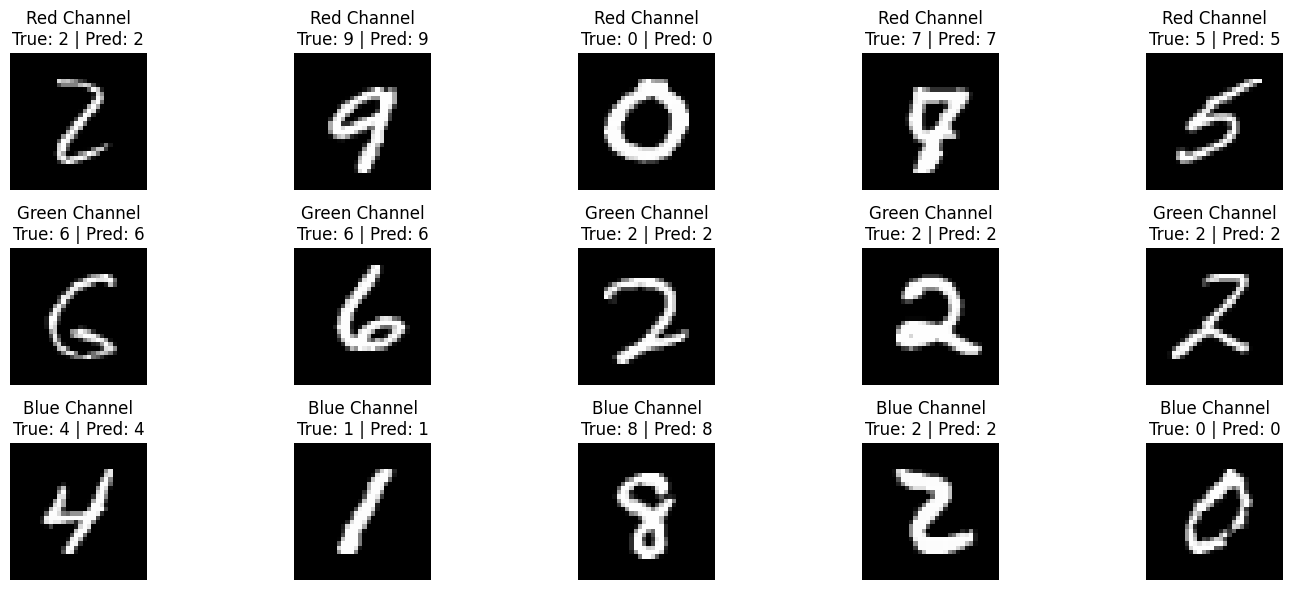

In [9]:
def evaluate_model(model, test_loader, device, num_samples=5):
    model.load_state_dict(torch.load(
        '/kaggle/input/weights/best_model_epoch14.pth',
        map_location=device,
        weights_only=True
    ))
    model = model.to(device)
    model.eval()
    
    # Initialize storage
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            # Get predictions
            hundreds, tens, units = model(images)
            preds = torch.stack([
                hundreds.argmax(1),
                tens.argmax(1),
                units.argmax(1)
            ], dim=1)  # Shape: [batch_size, 3]
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.concatenate(all_preds)  # Shape: [N, 3]
    # Corrected label loading
    all_labels = np.concatenate(all_labels)  # Shape: [N, 3]

# Assert
    assert len(all_preds) == len(all_labels), \
    f"Mismatch: {len(all_preds)} predictions vs {len(all_labels)} labels"

# Digit-wise split
    true_h = all_labels[:, 0]
    true_t = all_labels[:, 1]
    true_u = all_labels[:, 2]

    
    # Convert predictions to 1D arrays
    pred_h = all_preds[:, 0].flatten().astype(int)
    pred_t = all_preds[:, 1].flatten().astype(int)
    pred_u = all_preds[:, 2].flatten().astype(int)
    
    # Calculate F1 scores
    f1_h = f1_score(true_h, pred_h, average='macro', zero_division=0)
    f1_t = f1_score(true_t, pred_t, average='macro', zero_division=0)
    f1_u = f1_score(true_u, pred_u, average='macro', zero_division=0)
    avg_f1 = np.mean([f1_h, f1_t, f1_u])
    
    print(f"Channel-wise F1 Scores:")
    print(f"Hundreds Digit: {f1_h:.4f}")
    print(f"Tens Digit:     {f1_t:.4f}")
    print(f"Units Digit:    {f1_u:.4f}")
    print(f"\nComposite F1: {avg_f1:.4f}")
    
    # Visualization with channel decomposition
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))
    for i in range(num_samples):
        idx = np.random.randint(len(test_loader.dataset))
        img, label = test_loader.dataset[idx]
        
        # Get prediction
        with torch.no_grad():
            h, t, u = model(img.unsqueeze(0).to(device))
            pred = [h.argmax().item(), t.argmax().item(), u.argmax().item()]
        
        # Prepare image
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Denormalize
        
        # Split channels
        for ch in range(3):
            axes[ch, i].imshow(img[..., ch], cmap='gray')
            true_digit = int(label[ch])  # ✅ Proper extraction
            axes[ch, i].set_title(f"{['Red','Green','Blue'][ch]} Channel\nTrue: {true_digit} | Pred: {pred[ch]}")
            axes[ch, i].axis('off')

    
    plt.tight_layout()
    plt.show()
# Define your classifier class first (make sure it matches the saved model)
model = StackedMNISTClassifier()  # Replace with your actual class definition
model.load_state_dict(torch.load("/kaggle/input/weights/best_model_epoch14.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
evaluate_model(model, test_loader, device)

In [10]:
import wandb 
wandb.login(key='d89ae66ebff791665a63d7c56271d235ddcddcf9', relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hanafahim424 (hanafahim424-manipal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
from tqdm import tqdm

from scipy.stats import entropy
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 256
batch_size = 128
lr = 0.00015
imle_lambda = 0.4
epochs = 50
save_interval = 5
img_size = 32
channels = 3

wandb.init(project="GAN2", config={
    "latent_dim": latent_dim,
    "batch_size": batch_size,
    "lr": lr,
    "imle_lambda": imle_lambda,
    "epochs": epochs,
    'imle_lambda':0.7
})

class StackedMNISTDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)/255.0
        image = self.transform(image)
        return image, self.labels[idx]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size**2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        return self.conv_blocks(out)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size**2 * channels, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            #nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250412_045853-w9d0rx6q
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lilac-snow-3
wandb: ⭐️ View project at https://wandb.ai/hanafahim424-manipal/GAN2
wandb: 🚀 View run at https://wandb.ai/hanafahim424-manipal/GAN2/runs/w9d0rx6q


In [12]:
def get_real_distribution(dataloader):
    counts = defaultdict(int)
    for _, labels in dataloader:
        for label in labels.numpy():
            counts[label] += 1
    real_probs = np.zeros(1000) + 1e-7
    for k, v in counts.items():
        real_probs[k] = v
    return real_probs / real_probs.sum()

def calculate_metrics(generator, classifier, real_probs, n_samples=10000):
    generator.eval()
    combo_counts = defaultdict(int)
    batch_size = 500
    num_batches = n_samples // batch_size
    
    with torch.no_grad():
        for _ in range(num_batches):
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)
            #gen_imgs = torch.nn.functional.interpolate(gen_imgs, size=28)
            h, t, u = classifier(gen_imgs)
            h = h.argmax(1).cpu().numpy()
            t = t.argmax(1).cpu().numpy()
            u = u.argmax(1).cpu().numpy()
            for h_dig, t_dig, u_dig in zip(h, t, u):
                combo = h_dig * 100 + t_dig * 10 + u_dig
                combo_counts[combo] += 1
    
    mode_coverage = len(combo_counts)
    gen_probs = np.zeros(1000) + 1e-7
    for k, v in combo_counts.items():
        gen_probs[k] = v
    gen_probs /= gen_probs.sum()
    kl_div = entropy(real_probs, gen_probs)
    return mode_coverage, kl_div


In [13]:

dataset = StackedMNISTDataset('/kaggle/input/stacked-minst-labeled/stacked_mnist_labeled.npz')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
real_probs = get_real_distribution(DataLoader(dataset, batch_size=1024, shuffle=False))

classifier = StackedMNISTClassifier().to(device)
classifier.load_state_dict(torch.load('/kaggle/input/weights/best_model_epoch14.pth'))
classifier.eval()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

scaler_G = torch.cuda.amp.GradScaler()
scaler_D = torch.cuda.amp.GradScaler()


/tmp/ipykernel_19/1733954047.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('/kaggle/input/weights/best_model_epoch14.pth'))
/tmp/

In [14]:
import os
from torchvision.utils import save_image

# Create necessary directories inside /kaggle/working
os.makedirs("/kaggle/working/weights", exist_ok=True)
os.makedirs("/kaggle/working/samples", exist_ok=True)

for epoch in range(epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    epoch_imle_loss = 0.0
    num_batches = len(dataloader)
    
    for real_imgs, _ in tqdm(dataloader):
        real_imgs = real_imgs.to(device)
        current_batch_size = real_imgs.size(0)
        
        optimizer_D.zero_grad()
        with torch.cuda.amp.autocast():
            real_pred = discriminator(real_imgs)
            real_loss = -torch.mean(real_pred)
            z = torch.randn(current_batch_size, latent_dim, device=device)
            with torch.no_grad():
                fake_imgs = generator(z)
            fake_pred = discriminator(fake_imgs.detach())
            fake_loss = torch.mean(fake_pred)
            d_loss = real_loss + fake_loss
        
        scaler_D.scale(d_loss).backward()
        scaler_D.step(optimizer_D)
        scaler_D.update()

        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast():
            fake_imgs = generator(z)
            fake_pred = discriminator(fake_imgs)
            g_loss_adv = -torch.mean(fake_pred)
            real_flattened = real_imgs.view(current_batch_size, -1)
            fake_flattened = fake_imgs.view(current_batch_size, -1)
            distances = torch.cdist(real_flattened, fake_flattened)
            min_distances = torch.min(distances, dim=1)[0]
            imle_loss = torch.mean(min_distances)
            g_loss = g_loss_adv + imle_lambda * imle_loss
        
        scaler_G.scale(g_loss).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_imle_loss += imle_loss.item()
    
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    avg_imle_loss = epoch_imle_loss / num_batches
    mode_coverage, kl_div = calculate_metrics(generator, classifier, real_probs)
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Generator Loss: {avg_g_loss:.4f}")
    print(f"Discriminator Loss: {avg_d_loss:.4f}")
    print(f"IMLE Loss: {avg_imle_loss:.4f}")
    print(f"Mode Coverage: {mode_coverage}/1000")
    print(f"KL Divergence: {kl_div:.4f}")

    wandb.log({
        "Generator Total Loss": avg_g_loss,
        "Generator Adversarial Loss": avg_g_loss - imle_lambda * avg_imle_loss,  # g_loss_adv approx
        "IMLE Loss": avg_imle_loss,
        "Discriminator Loss": avg_d_loss,
        "Mode Coverage": mode_coverage,
        "KL Divergence": kl_div
    })

    
    if epoch % save_interval == 0:
        torch.save(generator.state_dict(), f"/kaggle/working/weights/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/kaggle/working/weights/discriminator_epoch_{epoch}.pth")
        with torch.no_grad():
            z = torch.randn(25, latent_dim, device=device)
            gen_imgs = generator(z)
            save_image(gen_imgs, f"/kaggle/working/samples/epoch_{epoch}.png", nrow=5, normalize=True)


  0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_19/3527374354.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_19/3527374354.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 1875/1875 [00:59<00:00, 31.49it/s]



Epoch 1/50
Generator Loss: -140.8206
Discriminator Loss: -0.4192
IMLE Loss: 25.1860
Mode Coverage: 351/1000
KL Divergence: 12.0433


100%|██████████| 1875/1875 [00:57<00:00, 32.35it/s]



Epoch 2/50
Generator Loss: -109.5894
Discriminator Loss: -0.0357
IMLE Loss: 25.2391
Mode Coverage: 316/1000
KL Divergence: 12.7025


100%|██████████| 1875/1875 [00:57<00:00, 32.36it/s]



Epoch 3/50
Generator Loss: -52.6067
Discriminator Loss: 0.0274
IMLE Loss: 23.8139
Mode Coverage: 572/1000
KL Divergence: 7.9599


100%|██████████| 1875/1875 [00:58<00:00, 32.29it/s]



Epoch 4/50
Generator Loss: -35.2749
Discriminator Loss: 0.0110
IMLE Loss: 23.5835
Mode Coverage: 580/1000
KL Divergence: 7.6931


100%|██████████| 1875/1875 [00:57<00:00, 32.42it/s]



Epoch 5/50
Generator Loss: -17.0848
Discriminator Loss: 0.0052
IMLE Loss: 23.4403
Mode Coverage: 527/1000
KL Divergence: 8.6285


100%|██████████| 1875/1875 [00:57<00:00, 32.44it/s]



Epoch 6/50
Generator Loss: -8.3246
Discriminator Loss: 0.0051
IMLE Loss: 23.3459
Mode Coverage: 557/1000
KL Divergence: 8.1204


100%|██████████| 1875/1875 [00:57<00:00, 32.44it/s]



Epoch 7/50
Generator Loss: -3.5169
Discriminator Loss: 0.0041
IMLE Loss: 23.2572
Mode Coverage: 497/1000
KL Divergence: 9.0553


100%|██████████| 1875/1875 [00:57<00:00, 32.47it/s]



Epoch 8/50
Generator Loss: 2.4876
Discriminator Loss: 0.0018
IMLE Loss: 23.1874
Mode Coverage: 626/1000
KL Divergence: 6.8127


100%|██████████| 1875/1875 [00:57<00:00, 32.47it/s]



Epoch 9/50
Generator Loss: 3.4305
Discriminator Loss: 0.0003
IMLE Loss: 23.1840
Mode Coverage: 554/1000
KL Divergence: 8.1564


100%|██████████| 1875/1875 [00:57<00:00, 32.40it/s]



Epoch 10/50
Generator Loss: 2.1561
Discriminator Loss: 0.0020
IMLE Loss: 23.2137
Mode Coverage: 613/1000
KL Divergence: 7.1227


100%|██████████| 1875/1875 [00:57<00:00, 32.44it/s]



Epoch 11/50
Generator Loss: 3.0456
Discriminator Loss: 0.0007
IMLE Loss: 23.1766
Mode Coverage: 621/1000
KL Divergence: 6.9898


100%|██████████| 1875/1875 [00:57<00:00, 32.43it/s]



Epoch 12/50
Generator Loss: 3.2966
Discriminator Loss: 0.0009
IMLE Loss: 23.1716
Mode Coverage: 619/1000
KL Divergence: 6.9929


100%|██████████| 1875/1875 [00:57<00:00, 32.48it/s]



Epoch 13/50
Generator Loss: 1.9795
Discriminator Loss: 0.0016
IMLE Loss: 23.2657
Mode Coverage: 685/1000
KL Divergence: 5.8682


100%|██████████| 1875/1875 [00:57<00:00, 32.43it/s]



Epoch 14/50
Generator Loss: 2.9335
Discriminator Loss: 0.0008
IMLE Loss: 23.2532
Mode Coverage: 687/1000
KL Divergence: 5.8914


100%|██████████| 1875/1875 [00:57<00:00, 32.44it/s]



Epoch 15/50
Generator Loss: 3.4733
Discriminator Loss: 0.0004
IMLE Loss: 23.2289
Mode Coverage: 717/1000
KL Divergence: 5.3189


100%|██████████| 1875/1875 [00:57<00:00, 32.42it/s]



Epoch 16/50
Generator Loss: -0.7500
Discriminator Loss: 0.0013
IMLE Loss: 23.3399
Mode Coverage: 742/1000
KL Divergence: 4.9076


100%|██████████| 1875/1875 [00:57<00:00, 32.42it/s]



Epoch 17/50
Generator Loss: -1.5231
Discriminator Loss: 0.0017
IMLE Loss: 23.4008
Mode Coverage: 697/1000
KL Divergence: 5.6410


100%|██████████| 1875/1875 [00:57<00:00, 32.50it/s]



Epoch 18/50
Generator Loss: -0.9346
Discriminator Loss: 0.0010
IMLE Loss: 23.3766
Mode Coverage: 704/1000
KL Divergence: 5.6299


100%|██████████| 1875/1875 [00:57<00:00, 32.41it/s]



Epoch 19/50
Generator Loss: 0.6567
Discriminator Loss: 0.0019
IMLE Loss: 23.3883
Mode Coverage: 791/1000
KL Divergence: 4.0731


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]



Epoch 20/50
Generator Loss: -0.0128
Discriminator Loss: -0.0008
IMLE Loss: 23.3525
Mode Coverage: 799/1000
KL Divergence: 3.9693


100%|██████████| 1875/1875 [00:57<00:00, 32.48it/s]



Epoch 21/50
Generator Loss: -2.1960
Discriminator Loss: 0.0017
IMLE Loss: 23.3918
Mode Coverage: 773/1000
KL Divergence: 4.4877


100%|██████████| 1875/1875 [00:57<00:00, 32.57it/s]



Epoch 22/50
Generator Loss: -2.1514
Discriminator Loss: 0.0016
IMLE Loss: 23.4010
Mode Coverage: 801/1000
KL Divergence: 3.9497


100%|██████████| 1875/1875 [00:57<00:00, 32.45it/s]



Epoch 23/50
Generator Loss: -3.1468
Discriminator Loss: 0.0004
IMLE Loss: 23.4544
Mode Coverage: 768/1000
KL Divergence: 4.4661


100%|██████████| 1875/1875 [00:57<00:00, 32.50it/s]



Epoch 24/50
Generator Loss: -4.4550
Discriminator Loss: 0.0016
IMLE Loss: 23.5136
Mode Coverage: 820/1000
KL Divergence: 3.5189


100%|██████████| 1875/1875 [00:57<00:00, 32.56it/s]



Epoch 25/50
Generator Loss: -4.8109
Discriminator Loss: 0.0015
IMLE Loss: 23.5237
Mode Coverage: 815/1000
KL Divergence: 3.7015


100%|██████████| 1875/1875 [00:57<00:00, 32.51it/s]



Epoch 26/50
Generator Loss: -4.9837
Discriminator Loss: 0.0020
IMLE Loss: 23.5351
Mode Coverage: 837/1000
KL Divergence: 3.2590


100%|██████████| 1875/1875 [00:57<00:00, 32.47it/s]



Epoch 27/50
Generator Loss: -5.3381
Discriminator Loss: 0.0018
IMLE Loss: 23.5331
Mode Coverage: 820/1000
KL Divergence: 3.6003


100%|██████████| 1875/1875 [00:57<00:00, 32.47it/s]



Epoch 28/50
Generator Loss: -6.9098
Discriminator Loss: 0.0027
IMLE Loss: 23.5598
Mode Coverage: 779/1000
KL Divergence: 4.2561


100%|██████████| 1875/1875 [00:57<00:00, 32.48it/s]



Epoch 29/50
Generator Loss: -9.1683
Discriminator Loss: 0.0033
IMLE Loss: 23.6371
Mode Coverage: 869/1000
KL Divergence: 2.7283


100%|██████████| 1875/1875 [00:57<00:00, 32.42it/s]



Epoch 30/50
Generator Loss: -7.9403
Discriminator Loss: 0.0017
IMLE Loss: 23.6463
Mode Coverage: 863/1000
KL Divergence: 2.7940


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]



Epoch 31/50
Generator Loss: -8.1834
Discriminator Loss: 0.0023
IMLE Loss: 23.6661
Mode Coverage: 883/1000
KL Divergence: 2.4828


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]



Epoch 32/50
Generator Loss: -9.7456
Discriminator Loss: 0.0036
IMLE Loss: 23.7013
Mode Coverage: 875/1000
KL Divergence: 2.5801


100%|██████████| 1875/1875 [00:57<00:00, 32.48it/s]



Epoch 33/50
Generator Loss: -9.7079
Discriminator Loss: 0.0027
IMLE Loss: 23.7110
Mode Coverage: 870/1000
KL Divergence: 2.7203


100%|██████████| 1875/1875 [00:57<00:00, 32.51it/s]



Epoch 34/50
Generator Loss: -10.5661
Discriminator Loss: 0.0041
IMLE Loss: 23.7404
Mode Coverage: 895/1000
KL Divergence: 2.1848


100%|██████████| 1875/1875 [00:57<00:00, 32.39it/s]



Epoch 35/50
Generator Loss: -11.7517
Discriminator Loss: 0.0048
IMLE Loss: 23.7797
Mode Coverage: 947/1000
KL Divergence: 1.3040


100%|██████████| 1875/1875 [00:57<00:00, 32.51it/s]



Epoch 36/50
Generator Loss: -10.4262
Discriminator Loss: 0.0030
IMLE Loss: 23.7751
Mode Coverage: 928/1000
KL Divergence: 1.6788


100%|██████████| 1875/1875 [00:57<00:00, 32.46it/s]



Epoch 37/50
Generator Loss: -10.3922
Discriminator Loss: 0.0037
IMLE Loss: 23.7938
Mode Coverage: 896/1000
KL Divergence: 2.1884


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]



Epoch 38/50
Generator Loss: -11.3303
Discriminator Loss: 0.0030
IMLE Loss: 23.8007
Mode Coverage: 906/1000
KL Divergence: 1.9738


100%|██████████| 1875/1875 [00:57<00:00, 32.41it/s]



Epoch 39/50
Generator Loss: -11.2887
Discriminator Loss: 0.0052
IMLE Loss: 23.8182
Mode Coverage: 935/1000
KL Divergence: 1.5019


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]



Epoch 40/50
Generator Loss: -12.0827
Discriminator Loss: 0.0037
IMLE Loss: 23.8260
Mode Coverage: 927/1000
KL Divergence: 1.6456


100%|██████████| 1875/1875 [00:57<00:00, 32.51it/s]



Epoch 41/50
Generator Loss: -11.5453
Discriminator Loss: 0.0028
IMLE Loss: 23.8110
Mode Coverage: 873/1000
KL Divergence: 2.6218


100%|██████████| 1875/1875 [00:57<00:00, 32.38it/s]



Epoch 42/50
Generator Loss: -11.9928
Discriminator Loss: 0.0034
IMLE Loss: 23.8420
Mode Coverage: 913/1000
KL Divergence: 1.8404


100%|██████████| 1875/1875 [00:57<00:00, 32.46it/s]



Epoch 43/50
Generator Loss: -13.9182
Discriminator Loss: 0.0030
IMLE Loss: 23.8566
Mode Coverage: 903/1000
KL Divergence: 2.0695


100%|██████████| 1875/1875 [00:57<00:00, 32.51it/s]



Epoch 44/50
Generator Loss: -14.9019
Discriminator Loss: 0.0052
IMLE Loss: 23.9154
Mode Coverage: 952/1000
KL Divergence: 1.2059


100%|██████████| 1875/1875 [00:57<00:00, 32.46it/s]



Epoch 45/50
Generator Loss: -15.1819
Discriminator Loss: 0.0031
IMLE Loss: 23.8802
Mode Coverage: 847/1000
KL Divergence: 3.0491


100%|██████████| 1875/1875 [00:57<00:00, 32.45it/s]



Epoch 46/50
Generator Loss: -15.0828
Discriminator Loss: 0.0035
IMLE Loss: 23.8929
Mode Coverage: 942/1000
KL Divergence: 1.3571


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]



Epoch 47/50
Generator Loss: -15.3006
Discriminator Loss: 0.0028
IMLE Loss: 23.9007
Mode Coverage: 915/1000
KL Divergence: 1.7970


100%|██████████| 1875/1875 [00:57<00:00, 32.50it/s]



Epoch 48/50
Generator Loss: -16.4717
Discriminator Loss: 0.0043
IMLE Loss: 23.9311
Mode Coverage: 880/1000
KL Divergence: 2.4506


100%|██████████| 1875/1875 [00:57<00:00, 32.52it/s]



Epoch 49/50
Generator Loss: -17.1837
Discriminator Loss: 0.0026
IMLE Loss: 23.9458
Mode Coverage: 934/1000
KL Divergence: 1.5077


100%|██████████| 1875/1875 [00:57<00:00, 32.53it/s]



Epoch 50/50
Generator Loss: -18.0160
Discriminator Loss: 0.0029
IMLE Loss: 23.9486
Mode Coverage: 898/1000
KL Divergence: 2.1359


In [15]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         Discriminator Loss ▁▇██████████████████████████████████████
wandb: Generator Adversarial Loss ▁▃▅▆▇████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:       Generator Total Loss ▁▃▅▆▇█████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:                  IMLE Loss ██▃▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:              KL Divergence ██▅▅▅▆▄▅▅▄▄▄▃▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▂▂
wandb:              Mode Coverage ▁▁▄▄▃▄▄▄▄▅▅▆▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇██▇██▇██▇██▇▇
wandb: 
wandb: Run summary:
wandb:         Discriminator Loss 0.0029
wandb: Generator Adversarial Loss -27.59547
wandb:       Generator Total Loss -18.01605
wandb:                  IMLE Loss 23.94857
wandb:              KL Divergence 2.13593
wandb:              Mode Coverage 898
wandb: 
wandb: 🚀 View run lilac-snow-3 at: https://wandb.ai/hanafahim424-manipal/GAN2/runs/w9d0rx6q
wandb: ⭐️ View project at: https://wandb.ai/hanafahim42